In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat
from uncertainties.umath import *

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=20)     # fontsize of the axes labels
plt.rc('axes', titlesize=20)     # fontsize of the plot title

## Functions (Don't need to change)

### Create the velocity profiles for VTOL and FW based on mission parameters

In [2]:
def d_v_profiles(cruise, acceleration, total_dist, dt, title, Graph = True):

    dist = (cruise**2)/(2*acceleration)   # distance when cruise speed is reached
    target = total_dist - dist            # start to slow down (velocity profile is symmetric)

    t = 0   # time (s)
    d = 0   # distance (m)
    v = 0   # velocity (m/s)

    time = [0]         # create lists to strore the values in
    distance = [0]
    velocity = [0]

    while(d < total_dist):                        # loop until the desired distance is reached
        if(d >= target):                          # slow down once target distance is reached
            v = v - acceleration*dt               # the velocity is decreasing
            d = d + (v*dt)                        # update the distance traveled
            t = t + dt                            # update the time

            time.append(t)                        # add all the new values to the lists
            distance.append(d)
            velocity.append(v)
        else:                                     # when the aircraft is accelerating
            if(v < cruise):
                v = v + acceleration*dt           # increase the velocity
            else:
                v = cruise                        # travel at a constant velocity at cruise
            d = d + (v*dt)                        # update distance
            t = t + dt                            # update time

            time.append(t)                        # add all the new values to the lists
            distance.append(d)
            velocity.append(v)
            
    velocity[-1] = 0    # force the last value to 0 if time step is too big (decreasing time step takes longer to run)
    
    if Graph:                                     # set Graph = True in function call to see the profiles
        plt.figure(figsize = [10, 4])
        plt.plot(time, velocity)
        plt.xlabel('Time [s]')
        plt.ylabel('Velocity [m/s]')
        plt.title(title)
        
        plt.figure(figsize = [10, 4])
        plt.plot(time, distance)
        plt.xlabel('Time [s]')
        plt.ylabel('Distance [m]')
        plt.title(title)
    
    return distance, velocity                     # return the distance and velocity arrays

### Use the FBD and velocity profiles to find the force and power needed by propellors in each stage of flight

In [3]:
def P_UP(mass, v, Cd_top):                       # vertical motion from ground up to cruise altitude
    # constants
    g = 9.81
    A_top = 32.41                                # area of the top of the aircraft m^2 (from open VSP)
    rho = 1.2                                    # density of air
    num_prop = 8                                 # number of VTOL propellors
    D_prop = 1.5                                 # VTOL propellor diameter (provided by SMSD)
    
    # forces (only vertical)
    Fg = mass*g                                  # force of gravity
    Fd = 0.5*rho*Cd_top*A_top*(v**2)             # drag force when moving vertically
    F_v = (Fg + Fd)/num_prop                     # thrust force per VTOL propellor
    F_h = 0                                      # no horizontal force
    
    # power (only vertical)
    A_prop = 0.25*np.pi*(D_prop)**2              # propellor area m^2
    P_v = F_v*((F_v/A_prop)*(1/(2*rho)))**0.5    # power per motor
    P_h = 0
     
    return P_h/1000, P_v/1000                    # return vertical and horizontal power in kW

In [4]:
def P_DOWN(mass, v, Cd_top):                     # Landing (assuming Cd_top = Cd_bottom)
    # constants
    g = 9.81
    A_top = 32.41                                # area of the top of the aircraft m^2
    rho = 1.2                                    # density of air
    num_prop = 8                                 # number of VTOL propellors
    D_prop = 1.5                                 # VTOL propllor dimater
    
    # forces (only vertical)
    Fg = mass*g                                  # force of gravity
    Fd = 0.5*rho*Cd_top*A_top*(v**2)             # drag force when moving vertically
    F_v = (Fg - Fd)/num_prop                     # thrust force per VTOL propellor
    F_h = 0                                      # no horizontal forces
    
    # power
    A_prop = 0.25*np.pi*(D_prop)**2              # propellor area m^2
    P_v = F_v*((F_v/A_prop)*(1/(2*rho)))**0.5    # power per motor
    P_h = 0
     
    return P_h/1000, P_v/1000                    # return horizontal and vertical power in kW

In [5]:
def P_FW(mass, v, Cd_front, Cl):                 # cruise portion of the flight

    # constants
    rho = 1.2
    g = 9.81
    A_front = 4.92                               # frontal area of the aircraft (open VSP)
    num_prop_v = 8                               # vertical propellors
    D_prop_v = 1.5                               # vertical proplellor diameter (horizontal not needed)
    num_prop_h = 2                               # horizontal propellors

    # vertical forces
    Fg = mass*g
    Fl = 0.5*rho*Cl*A_front*(v**2)               # lift force
    F_v = abs(Fg - Fl)/num_prop_v                # thrust force per propellor

    if((Fg - Fl) < 0):                           # notify user if cruise speed is too high
        print('Propellor force is downwards!')

    # vertical power
    A_prop = 0.25*np.pi*(D_prop_v)**2            # propellor area m^2
    P_v = F_v*((F_v/A_prop)*(1/(2*rho)))**0.5    # power per motor

    # horizontal forces
    Fd = 0.5*rho*Cd_front*A_front*(v**2)         # drag force

    # horizontal power
    P_h = (Fd*v)/num_prop_h                      # power per propellor

    return P_h/1000, P_v/1000                    # return horizontal and vertical power in kW

In [6]:
def integrator(time, values):                    # trapezoidal integration method (for integrating power curves)
    a = []
    for i in range(len(values)-1):
        temp = ((values[i] + values[i+1])/2)*(time[i+1] - time[i])
        a.append(temp)
    b = np.array(a)
    c = np.sum(b)
    return c     

### Combine the three stages of the flight into one overall power profile

In [7]:
def power_profile(mass, v_v, v_h, Cd_top, Cd_front, Cl, dt, safteyfactor, Graph = True):
    
    P_h_1 = []    # takeoff (horizontal)
    P_v_1 = []    # (vertical)
    
    P_h_2 = []    # cruise (horizontal)
    P_v_2 = []    # (vertical)
    
    P_h_3 = []    # landing (horizontal)
    P_v_3 = []    # (vertical)

    for i in range(len(v_v)):                             # _v represents the vertical componets of the flight
        Ph1, Pv1 = P_UP(mass[i], v_v[i], Cd_top)          # call P_UP (takeoff) function for each velocity value
        P_h_1.append(Ph1)                                 # store the power corresponding to each velocity
        P_v_1.append(Pv1)
    
    for j in range(len(v_h)):                             #_h is for the cruise (horizontal) portions of the flight
        Ph2, Pv2 = P_FW(mass[j], v_h[j], Cd_front, Cl)    # call P_FW (cruise) for each velocity value
        P_h_2.append(Ph2)
        P_v_2.append(Pv2)
        
    for k in range(len(v_v)):                             # landing - same valocity profile as takeoff
        Ph3, Pv3 = P_DOWN(mass[k], v_v[k], Cd_top)        # call the P_DOWN (landing) function for each velocity
        P_h_3.append(Ph3)
        P_v_3.append(Pv3)

    # combine the lists together (safetyfactor accounts for propellor and motor efficiencies - to find needed input power)
    P_h = np.array(P_h_1 + P_h_2 + P_h_3)*safteyfactor    # full trip horizontal power
    P_v = np.array(P_v_1 + P_v_2 + P_v_3)*safteyfactor    # full trip vertical power
    
    # find the power capacity used during cruise
    elapsed_t = dt*(len(P_h_2))                           # find the time spent in cruise
    t = np.linspace(0, elapsed_t, len(P_h_2)+1)           # create a time array for cruise
    T = np.delete(t, -1)                                  # delete the last value so the array is the correct size     
    PH = integrator(T, P_h_2)*(2/3600)                    # find total energy used by horizontal motors (2)
    PV = integrator(T, P_v_2)*(8/3600)                    # find total energy used by vertical motors (8)
    P_CRUISE = (PH+PV)*safteyfactor                       # find total energy (multiply by safteyfactor to get input energy)
    
    # find time elapsed for whole trip
    elapsed_time = dt*(len(P_h)) 
    time = np.linspace(0, elapsed_time, len(P_h)+1)
    TIME = np.delete(time, -1)                            # time array that is the correct size with correct time step
    
    if Graph:                                             # set Graph = True to plot the power profiles
        plt.figure(figsize = [11, 7])
        plt.plot(TIME/60, P_h, label = 'FW Propellor Power')
        plt.plot(TIME/60, P_v, label = 'VTOL Propellor Power')
        plt.xlabel('Time [min]')
        plt.ylabel('Power [kW]')
        plt.title('Power Output Per Propellor')
        plt.legend(fontsize = 15)
        plt.yticks([0, 10, 20, 30, 40, 50, 60, 70])
        
        plt.axvline(TIME[len(P_h_1)]/60, linestyle = '--', color = 'green')
        plt.axvline(TIME[len(P_h_1)+len(P_h_2)]/60, linestyle = '--', color = 'green')
        plt.axvline(TIME[len(P_h_3)]/60, linestyle = '--', color = 'green')
    
    return TIME, P_h, P_v, P_CRUISE

In [8]:
 def total_power(time, P_h, P_v, P_cruise, Verbose = True):
    P_vtol = integrator(time, P_v)*(8/3600)               # find the total energy used by VTOL motors
    P_fw = integrator(time, P_h)*(2/3600)                 # find total energy used by FW motors
    
    P_total = P_vtol + P_fw                               # find the total energy consumed during the flight
    
    if Verbose:                                           # set Verbose = True to print everything
        print('Vertical Propellors -  Power Capacity %0.2f kWh' %P_vtol)
        print('Vertical Propellors -  Peak Power % 0.2f kW per propellor' %(np.max(P_v)))
        print('Horizontal Propellors - Power Capacity %0.2f kWh' %P_fw)
        print('Horizontal Propellors - Peak Power % 0.2f kW per propellor' %(np.max(P_h)))
        print('\nTotal Power Capacity %0.2f kWh' %P_total)
        print('Total Trip Time %0.2f minutes' %(time[-1]/60))
        
        print('\nPower Consumption - Cruise %0.2f kWh' %P_cruise)
        print('Power Consumption - VTOL %0.2f kWh' %(P_total - P_cruise))
    
    return P_vtol, P_fw, P_total

### Was intended to have the fuel mass decay over the flight (used currently just as a constant value)

In [9]:
def mass_decay(m_total, m_fuel, a1, a2):
    length = a1 + a2 + a1                           # create an array the length of the simulation
    m1 = np.ones(len(length))*m_total               # create an array with all values = MTOW
    m2 = np.linspace(0, m_fuel, len(length))        # create an array of values that decays the fuel mass over the flight
    
    MASS = m1-m2                                    # total mass decreases by the amount of fuel that is used
    return MASS

### Function used for battery sizing

In [10]:
def battery(peak, power, cooling_mass_percent, Verbose = True):         # power is in WATTS
    
    # Peak = the peak power needed during the flight
    # Power = the required battery power (Peak - Turbogenerator Power)

    Cap_battery = 20                    # capacity (Ah) of Greypow battery being suggested
    Dis_rate = 5                        # 5C max discharge rate
    m_battery = 1.8                     # each battery is 1.8 kg
    V_battery = 22.2                    # each battery is 22.2 Volts
    A_battery = Cap_battery*Dis_rate    # max current that the battery can discharge

    # find the motor voltage based on the power supplied to each motor
    # gotten from ERMAX 268 data sheet, assumed linear relationship between provided values (peak and continuous power)
    # ERMAX 268 has a low, med and high voltage model (all same mass), choose model that produces lightest battery
    
    V_low = (peak/8 + 1E6)/6055.6         # relationships created by fitting a linear model in excel
    V_med = (peak/8 + 2E6)/5177.5         # plotted the peak and continuous voltage and power from data sheet
    V_high = (peak/8 + 834286)/1553.6     # assumed a linear relationship (explained more in report)
    
    A_low = power/V_low                   # Find the total current that the battery must supply
    A_med = power/V_med                   # Depends on power and motor voltage (different for each model)
    A_high = power/V_high

    V = []                                # create a list with the voltage for each model
    V.append(V_low)
    V.append(V_med)
    V.append(V_high)
    Volts = np.array(V)

    A = []                                # create a list with the current for each model
    A.append(A_low)
    A.append(A_med)
    A.append(A_high)
    Amps = np.array(A)

    series = []                           # number of cells in series for each motor model
    parallel = []                         # number of cells in parallel for each motor model
    total = []                            # total cells needed for each motor model
    capacity = []                         # energy capacity of each battery pack (kWh)
    specific_energy = []                  # specific energy of each battery pack (Wh/kg)

    for i in range(len(Volts)):
        s = np.math.ceil(Volts[i]/V_battery)            # cells in series, round up
        p = np.math.ceil(Amps[i]/A_battery)             # cells in parallel, round up
        cap = Volts[i]*p*Cap_battery/1000               # energy capacity of pack in kWh
        tot = s*p                                       # total number of cells
        se = (Volts[i]*p*Cap_battery)/(tot*m_battery)   # specific energy of pack
        
        series.append(s)                                # add all the values for each motor to the lists
        parallel.append(p)
        capacity.append(cap)
        total.append(tot)
        specific_energy.append(se)
    
    mass = (np.array(total)*m_battery)*cooling_mass_percent    # add additional mass to battery pack for cooling
    
    if Verbose:                                                # set Verbose = True to print all these values
        print('Cells in series:', series)
        print('Cells in parallel:', parallel)
        print('Capacity of battery pack (kWh):', capacity)
        print('Total cells in pack:', total)
        print('Specific energy of pack (Wh/kg):', specific_energy)
        print('Mass of pack (kg):', mass)
    
    return mass,total, capacity, series, parallel

### New plotter to "break" the x-axis of the power profile plot (don't need to use)

In [11]:
# def power_profile(mass, v_v, v_h, Cd_top, Cd_front, Cl, dt, safteyfactor, Graph = True):
    
#     P_h_1 = []    # takeoff
#     P_v_1 = []
    
#     P_h_2 = []    # cruise
#     P_v_2 = []
    
#     P_h_3 = []    # landing
#     P_v_3 = []

#     for i in range(len(v_v)):
#         Ph1, Pv1 = P_UP(mass[i], v_v[i], Cd_top)
#         P_h_1.append(Ph1)
#         P_v_1.append(Pv1)
    
#     for j in range(len(v_h)):
#         Ph2, Pv2 = P_FW(mass[j], v_h[j], Cd_front, Cl)
#         P_h_2.append(Ph2)
#         P_v_2.append(Pv2)
        
#     for k in range(len(v_v)):
#         Ph3, Pv3 = P_DOWN(mass[k], v_v[k], Cd_top)
#         P_h_3.append(Ph3)
#         P_v_3.append(Pv3)

#     P_h = np.array(P_h_1 + P_h_2 + P_h_3)*safteyfactor    # full trip horizontal power
#     P_v = np.array(P_v_1 + P_v_2 + P_v_3)*safteyfactor   # full trip vertical power
    
#     # find the power capacity used during cruise
#     elapsed_t = dt*(len(P_h_2))
#     t = np.linspace(0, elapsed_t, len(P_h_2)+1)
#     T = np.delete(t, -1)
#     PH = integrator(T, P_h_2)*(2/3600)
#     PV = integrator(T, P_v_2)*(8/3600)
#     P_CRUISE = (PH+PV)*safteyfactor
    
#     # find time elapsed for whole trip (could also use P_v)
#     elapsed_time = dt*(len(P_h)) 
#     time = np.linspace(0, elapsed_time, len(P_h)+1)
#     TIME = np.delete(time, -1)
    
#     if Graph:
#         plt.figure(figsize = [12, 7])
        
#         f,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w', figsize = [11,7])

#         ax.plot(TIME/60, P_h, label = 'FW Propellor Power')
#         ax.plot(TIME/60, P_v, label = 'VTOL Propellor Power')
#         ax.axvline(TIME[len(P_h_1)]/60, linestyle = '--', color = 'green')
        
#         ax2.plot(TIME/60, P_h, label = 'FW Propellor Power')
#         ax2.plot(TIME/60, P_v, label = 'VTOL Propellor Power')
#         ax2.axvline(TIME[len(P_h_1)+len(P_h_2)]/60, linestyle = '--', color = 'green')
        
#         ax.set_xlim(-0.02, 3)
#         ax2.set_xlim(35, 0.02 + TIME[-1]/60)

#         ax.spines['right'].set_visible(False)
#         ax2.spines['left'].set_visible(False)
#         ax.yaxis.tick_left()
#         ax2.yaxis.tick_right()

#         d = 0.015
#         kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
#         ax.plot((1-d,1+d), (-d,+d), **kwargs)
#         ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

#         kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
#         ax2.plot((-d,+d), (1-d,1+d), **kwargs)
#         ax2.plot((-d,+d), (-d,+d), **kwargs)

#         ax.set_title('Power Output per Propellor\n')
#         ax.set_xlabel('Time [min]')
#         ax.set_ylabel('Power [kW]')
#         plt.legend(fontsize = 15, loc = (-0.52,0.8))
#         plt.yticks([0, 10, 20, 30, 40, 50, 60, 70])
    
#     return TIME, P_h, P_v, P_CRUISE

### Used for Sensitivity Analysis

Steps:

1) Create an empty list for whatever variable you want to modify ex: prop_e (in a seperate cell)

2) Use FACTOR to vary the variable (1.2 = increase it by 20%)

3) Multiply prop_eff by FACTOR

4) Uncomment the append.prop_e line to store the new value

5) Rerun the cell with different FACTOR values

6) Once you are done with the variable you can go to the next cell and print prop_e, then copy and paste the values into an array so you dont lose them

7) Move on to the next variable (ex: vtol) and mutliply the appropriate variable by FACTOR and uncomment the appropriate line (only one append line should be uncommented at a time)

In [12]:
# prop_e = [] 
# vtol = []
# vtol_a = []
# alt = []
# fw = []
# fw_a = []
# dist = []
# M = []

In [13]:
# FACTOR = 1.2

# prop_eff = 0.80
# motor_eff = 0.955
# safteyfactor = (1/(prop_eff*motor_eff))     # accounts for efficencies and power losses through system

# dt = 0.1                         # time step
# cruise_vtol = 6                  # cruise speed for VTOL (m/s)
# acceleration_vtol = 0.2 * 9.81   # accelration in g's
# total_dist_vtol = 610            # total distance traveled (cruise altitude)

# cruise_fw = 250/3.6              # cruise speed for FW (m/s)
# acceleration_fw = 0.4 * 9.81     # acceleration in g's
# total_dist_fw = 150000           # total distance traveled (trip range - will increase later)

# # Cd and Cl values (once we figure these out they can be put into the functions)
# Cd_top = 1                 # drag coeffiecient (top of plane) - approximated as a square
# Cd_front = 0.07            # drag coefficient for the front of the aircraft - open VSP
# Cl = 1.1                   # lift coefficent for the aircraft - open VSP

# d_vtol, v_vtol = d_v_profiles(cruise_vtol, acceleration_vtol, total_dist_vtol, dt, 'VTOL', Graph = False)
# d_fw, v_fw = d_v_profiles(cruise_fw, acceleration_fw, total_dist_fw, dt, 'FW', Graph = False)

# mass = mass_decay(1800*0.9, 0, v_vtol, v_fw) 

# time, P_h, P_v, P_cruise = power_profile(mass, v_vtol, v_fw, Cd_top, Cd_front, Cl, dt, safteyfactor, Graph = True)

# P_VTOL_cap, P_FW_cap, P_TOTAL_cap = total_power(time, P_h, P_v, P_cruise, Verbose = True)

# prop_e.append(P_TOTAL_cap)      # uncomment these one at a time as you change factor
# vtol.append(P_TOTAL_cap)        # you could do a sensitivity analysis on another variable other than total energy
# vtol_a.append(P_TOTAL_cap)
# alt.append(P_TOTAL_cap)
# fw.append(P_TOTAL_cap)
# fw_a.append(P_TOTAL_cap)
# dist.append(P_TOTAL_cap)
# M.append(P_TOTAL_cap)

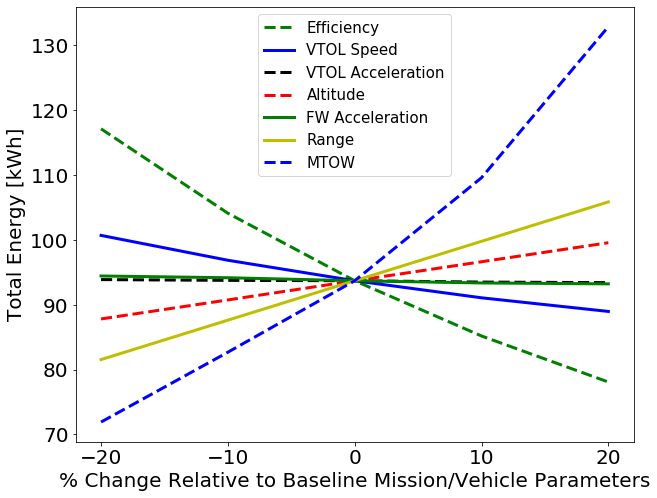

In [14]:
# results from the sensitivity analysis in the report

X = [-20, -10, 0, 10, 20] 

eff = [117.13805481570253,104.12271539173562,93.71044385256205,85.19131259323825,78.09203654380173]

vtol = [100.70315265737213,96.86948268953381,93.71044385256205,91.079671055234,88.97722203704038]

vtol_a = [93.88619042238037,93.76902787271644,93.71044385256205,93.50540599500081,93.4175181937665]

alt = [87.81915521859781,90.75015317764542,93.71044385256205,96.64144181160964,99.57243977065721]

fw = [154.17938245711213,111.18603400793916,93.71044385256205,93.71044385256205,93.71044385256205]

fw_a = [94.44406421073995,94.17456398736218,93.71044385256205,93.36840931691472,93.22981204421538]

dist = [81.55215320957672,87.6312985310694,93.71044385256205,99.78958917405481,105.86873449554747]

M = [71.92,82.69,93.71044385256205,109.60020103763226,132.89199574116617]

plt.figure(figsize = [10,8])
plt.plot(X, eff, 'g--', label = 'Efficiency', linewidth = 3)
plt.plot(X, vtol, 'b-', label = 'VTOL Speed', linewidth = 3)
plt.plot(X, vtol_a, 'k--', label = 'VTOL Acceleration', linewidth = 3)
plt.plot(X, alt, 'r--', label = 'Altitude', linewidth = 3)
plt.plot(X, fw_a, 'g-', label = 'FW Acceleration', linewidth = 3)
plt.plot(X, dist, 'y-', label = 'Range', linewidth = 3)
# plt.plot([-20,-10,0,0,0], fw, 'r-o', label = 'FW Speed', linewidth = 3)
plt.plot(X, M, 'b--', label = 'MTOW', linewidth = 3)
plt.xticks([-20, -10, 0, 10, 20])
plt.xlabel('% Change Relative to Baseline Mission/Vehicle Parameters')
plt.ylabel('Total Energy [kWh]')
plt.legend(fontsize = 15)

plt.savefig('SENS')

## Simulation

Propellor efficency (https://www.dglr.de/publikationen/2017/450176.pdf)

Vertical Propellors -  Power Capacity 34.00 kWh
Vertical Propellors -  Peak Power  69.98 kW per propellor
Horizontal Propellors - Power Capacity 60.33 kWh
Horizontal Propellors - Peak Power  53.43 kW per propellor

Total Power Capacity 94.33 kWh
Total Trip Time 37.86 minutes

Power Consumption - Cruise 63.73 kWh
Power Consumption - VTOL 30.60 kWh


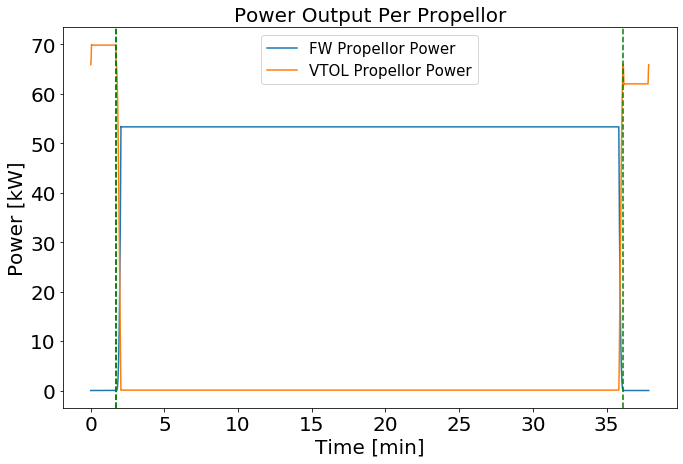

In [15]:
#----------------------------MISSION PARAMETERS------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------
MTOW = 1800  
prop_eff = 0.8                              # propellor efficiency
motor_eff = 0.955                           # motor efficiency
safteyfactor = (1/(prop_eff*motor_eff))     # accounts for efficencies and power losses through system

dt = 0.1                                    # time step
cruise_vtol = 6                             # cruise speed for VTOL (m/s)
acceleration_vtol =  0.2* 9.81              # accelration in g's
total_dist_vtol = 610                       # total distance traveled (m) (cruise altitude)

cruise_fw = 264/3.6                         # cruise speed for FW (m/s)
acceleration_fw =  0.4* 9.81                # acceleration in g's
total_dist_fw = 150000                      # total distance traveled (m) (trip range)

Cd_top = 1                 # drag coeffiecient (top of plane) - approximated as a cube (conservative value)
Cd_front = 0.07            # drag coefficient for the front of the aircraft - open VSP
Cl = 1.1                   # lift coefficent for the aircraft - open VSP
#----------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

# build the distance and velocity profiles for VTOL and FW
d_vtol, v_vtol = d_v_profiles(cruise_vtol, acceleration_vtol, total_dist_vtol, dt, 'VTOL', Graph = False)
d_fw, v_fw = d_v_profiles(cruise_fw, acceleration_fw, total_dist_fw, dt, 'FW', Graph = False)

# a constant mass is being used (fuel mass is set to zero so nothing decays)
mass = mass_decay(MTOW, 0, v_vtol, v_fw)

# call the power profile function
time, P_h, P_v, P_cruise = power_profile(mass, v_vtol, v_fw, Cd_top, Cd_front, Cl, dt, safteyfactor, Graph = True)

# call the total power function
P_VTOL_cap, P_FW_cap, P_TOTAL_cap = total_power(time, P_h, P_v, P_cruise, Verbose = True)

# -------------------------------------------------------------------------------------------------------------
## Turbine Selection (Start Iterating Here)

Use the simulation above to find the power requirements then iterate this code to pick your tubine and battery sizes that give you a desirable power system mass, battery capacity, fuel consumption, DOH, etc...

Sections that are meant to be iterated/changed are surrounded by: 

#-----------------------------------------
#------------------------------------------

In [29]:
P_h_total = P_h*2                     # total power for horizontal props
P_v_total = P_v*8                     # total power for vertical props

P_h_max = np.max(P_h_total)           # find the maximum horizotnal power
P_v_max = np.max(P_v_total)           # find the maximum vertical power

#--------------------------------------------------------------------------------------------------------------
#-------------------ADJUST THE TURBOGENERATOR SIZE HERE---------------------------------------------------------

P_turbogen = 250                      # basline power supplied by the turbogen (kW)

#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------

P_h_battery = []
P_v_battery = []

for i in range(len(P_h_total)):        # battery power needed for VTOL motors
    if P_h_total[i] >= P_turbogen:     # keep track of any power above what the turbogerator is supplying
        P_h_battery.append(P_h_total[i] - P_turbogen)    # add the surplus power values to a list
    else:
         P_h_battery.append(0)                           # add a zero if the turbogenrator supplies enough power

for i in range(len(P_v_total)):        # battery power needed for FW motors (same as VTOL)
    if P_v_total[i] >= P_turbogen:
        P_v_battery.append(P_v_total[i] - P_turbogen)
    else:
         P_v_battery.append(0)
            
#---------------------------------------------------------------------------------------------------------------
#------------------------TURN TURBINE OFF DURING CRUISE---------------------------------------------------------
# you can modify t_cruise, t_off and P_charge
# P_charge needs to be a minium of whatevery power is needed during cruise (based on our values - 107 kW)
# increase P_charge if you want to charge the batteries during cruise
 
t_cruise = 33                         # time spent in cruise (min)
time_cruise = t_cruise*60             # seconds

t_off = 22                             # turn the turbine off during cruise if there is excess capacity (min)
time_off = t_off*60                   # seconds

P_charge = 183                        # adjust this value to control the turbogenerator power during cruise      
t_charge = t_cruise - t_off           # charge while in cruise and the turbogenerator is on                 
time_charge = t_charge*60             # seconds
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------

# find the battery needed in kWh for the flight
Battery_cap = (integrator(time, P_v_battery))/3600 + (integrator(time, P_h_battery))/3600 + (time_off*P_h_max)/3600

# find the fuel needed in kWh for the flight
Fuel_cap = P_turbogen*(time[-1] - time_cruise)/3600 + P_charge*(time_charge)/3600

print('Max horizontal power (kW):', P_h_max)
print('Max vertical power (kW):', P_v_max)
print('Battery capacity needed (kWh):', Battery_cap)
print('Fuel capacity needed (kWh):', Fuel_cap)
print('Degree of hybridization (%):', (Battery_cap/(Fuel_cap + Battery_cap))*100)

Max horizontal power (kW): 106.86435044467181
Max vertical power (kW): 559.8153831177357
Battery capacity needed (kWh): 56.36241674298161
Fuel capacity needed (kWh): 53.80694444444446
Degree of hybridization (%): 51.159792646065014


### Used to find how much battery is used during takeoff and landing

In [17]:
x = 5000
# plt.plot(time[0:x], P_h_battery[0:x])       # used the plot to check that x accounts for the entire takeoff
# plt.plot(time[0:x], P_v_battery[0:x])

Battery_cap_takeoff = (integrator(time[0:x], P_v_battery[0:x]))/3600 + (integrator(time[0:x], P_h_battery[0:x]))/3600
Battery_cap_landing = (integrator(time[x:], P_v_battery[x:]))/3600 + (integrator(time[x:], P_h_battery[x:]))/3600

print('Takeoff Battery Capacity (kWh):', Battery_cap_takeoff)
print('Landing Battery Capacity (kWh):', Battery_cap_landing)

Takeoff Battery Capacity (kWh): 9.515625971831716
Landing Battery Capacity (kWh): 7.663195608103564


### Turbine and fuel
It is assumed that a Honeywell turbogenerator will be avialable in a size ranging from 5 to 250 kW (stated on website). Due to lack of information the power density of a turbine and generator will be considered seperatley and will be assumed to be the same as the turbogenerator.

RRM250: 73 kg - 330 kW (from proposal)

250 KW Gen: 75 kg - 250 kW (https://aerospace.honeywell.com/content/dam/aerobt/en/documents/learn/products/electric-power/brochures/250KW_Generator-ps.pdf)

5 to 250 kW range (https://aerospace.honeywell.com/us/en/learn/products/electric-power/hybrid-electric-electric-propulsion)

SFC values (https://aerospace.honeywell.com/content/dam/aerobt/en/documents/learn/products/engines/brochures/N61-1733-000-000-T53-v6-bro.pdf)

It was difficult to find values for specific fuel capacity. We used the graph in the link above and linearly extrpolated to our power values to find the SFC at out power values

In [30]:
Turbine_density = 73/330            # power density of RRM250 - from proposal (kg/kW)
Gen_density = (73/2.2)/250          # honeywell 250 kW (kg/kW)

# mass is found by using the power densities of similar sized turbogenrators
mass_turbogen = Turbine_density*P_turbogen + Gen_density*P_turbogen

# used to find the SFC for our power output
slope = (0.4328 - 0.3969)/(895 - 671)         # gotten from Honeywell data sheet 
SFC = 0.4328 + (671 - P_turbogen)*slope       # (kg/kw-h) interpolate to find value based on power (assumed linear)

#------------------------FUEL RESERVE---------------------------------------------------------------------------------
fuel_reserve = 1.05                           # used a 5% fuel reserve
#---------------------------------------------------------------------------------------------------------------------

mass_fuel = SFC*Fuel_cap*fuel_reserve

print('The mass of the turbogenerator is (kg):', mass_turbogen)
print('The mass of fuel needed is (kg):', mass_fuel)

The mass of the turbogenerator is (kg): 88.48484848484848
The mass of fuel needed is (kg): 28.264056478515638


## Battery Selection
https://www.grepow.com/page/uav-battery.html

https://www.grepow.com/page/nmc-811-battery.html

In [19]:
P_battery = (P_v_max - P_turbogen)*1000           # find the power that the battery must supply (in Watts)
print('The battery needs to be able to supply (kW):', P_battery/1000)

#------------------------COOLING SYSTEM--------------------------------------------------------------------------------
Cooling = 1.1                                 # assumed 10% extra mass for battery cooling system
#---------------------------------------------------------------------------------------------------------------------

# results are printed as [low, medium, high] corresponded tot he voltage of the motor
m_battery, num_battery, cap_bat, series, parallel = battery(P_v_max, P_battery, Cooling , Verbose = True)

The battery needs to be able to supply (kW): 309.8153831177357
Cells in series: [8, 18, 25]
Cells in parallel: [19, 9, 6]
Capacity of battery pack (kWh): [62.75622419424963, 69.5340600378793, 64.44562128652599]
Total cells in pack: [152, 162, 150]
Specific energy of pack (Wh/kg): [229.37216445266677, 238.45699601467524, 238.68748624639255]
Mass of pack (kg): [300.96 320.76 297.  ]


### Choose the motor with the lowest battery pack mass (all motors are 20.5 kg)
### 0 = low voltage, 1 = medium voltage, 2 = high voltage

In [20]:
#----------------------SELECT MOTOR----------------------------------------------------------------------------------
motor_num = 2
#---------------------------------------------------------------------------------------------------------------------

volume = 0.189*0.076*0.058*(num_battery[motor_num])     # find the volume of the selected battery pack
capacity_battery = cap_bat[motor_num]                   # find the capacity (kWh) of the selected pack

mass_battery = m_battery[motor_num]                     # find the mass of the selected pack

print('The mass of the battery pack is (kg):', mass_battery)
print('The total volume of the battery back is (m^3):', volume)
print('\nBattery capacity needed (kWh):', Battery_cap)
print('The capacity of the battery pack is (kWh):', capacity_battery)
print('Surplus Battery Capacity (kWh):', capacity_battery - Battery_cap)

P_charge = 20*(series[motor_num])*parallel[motor_num]*25.2    # fins the power needed for charging (see report for detail)

print('\nPower needed to charge battery at max rate (kW):', P_charge/1000)

The mass of the battery pack is (kg): 297.0
The total volume of the battery back is (m^3): 0.1249668

Battery capacity needed (kWh): 17.178821579935274
The capacity of the battery pack is (kWh): 64.44562128652599
Surplus Battery Capacity (kWh): 47.26679970659072

Power needed to charge battery at max rate (kW): 75.6


### Check that the battery capacity here is greater than the value in "Turbine Selection" - first cell of iteration

The battery capacity printed here limits the time that the turbogenerator can be turned off (if you want that option)

Typically mulyiply the value printed here by 0.9 (90% DOD) then increase "Time_off" in the first cell until you use all the available capacity

## Power System Mass

In [21]:
num_props = 10                               # 10 total propellors
mass_motors = 20.5*num_props                 # mass of each propellor (ERMAX 268)
mass_props = 4.15*num_props                  # mass of propellors (carbon fiber - made in CAD)

#---------------------------------------------------------------------------------------------------------------------
extra_mass = 10                              # extra mass to account for wiring, alternator or anything else (kg)
#---------------------------------------------------------------------------------------------------------------------

mass_total = (mass_props + mass_motors + mass_battery + mass_fuel + mass_turbogen) + extra_mass

print('The power system mass is (kg):', mass_total)

The power system mass is (kg): 683.5386510414892


Can adjust values thoughout the iteration section to get a desired total mass

## End of Iteration
## ---------------------------------------------------------------------------------------------------------------------------------

## Plots used in the report
Made by recording the results of the imulation for various inputs

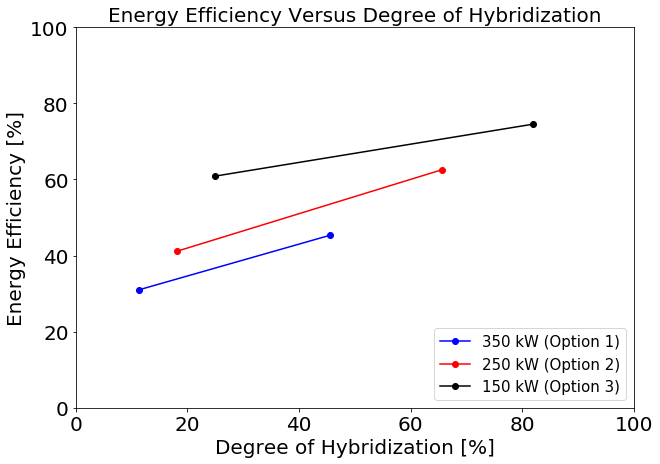

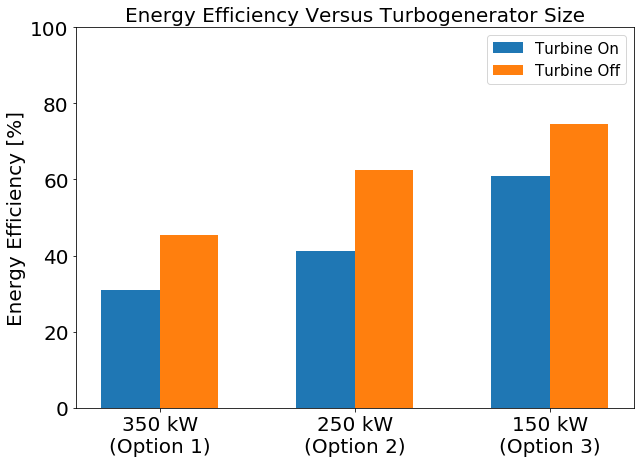

In [22]:
width = 0.3

x1 = [1 - 0.5*width,2 - 0.5*width ,3 - 0.5*width]
x2 = [1 + 0.5*width,2 + 0.5*width ,3 + 0.5*width]

# input power in kWh
P_opt1 = np.array([230.7, 157.86])
P_opt2 = np.array([174.1, 114.47])
P_opt3 = np.array([117.63, 96.07])

P_on = np.array([230.7, 174.1, 117.63])
P_off = np.array([157.86, 114.47, 96.07])

# output power in kWh
eff = (0.8*0.955)
P_out = 93.71*eff

# energy effiecincies for each option
E_opt1 = (P_out/P_opt1)*100
E_opt2 = (P_out/P_opt2)*100
E_opt3 = (P_out/P_opt3)*100

E_off = (P_out/P_off)*100
E_on = (P_out/P_on)*100

labels = ['350 kW', '250 kW', '150 kW']

plt.figure(figsize = [10,7])
plt.plot([11.4,45.6],E_opt1, 'bo-', label = '350 kW (Option 1)')
plt.plot([18.1,65.6],E_opt2, 'ro-', label = '250 kW (Option 2)')
plt.plot([24.9,81.9],E_opt3, 'ko-', label = '150 kW (Option 3)')
plt.xticks([0,20,40,60,80,100])
plt.yticks([0,20,40,60,80,100])
plt.xlabel('Degree of Hybridization [%]')
plt.ylabel('Energy Efficiency [%]')
plt.title('Energy Efficiency Versus Degree of Hybridization')
plt.legend(fontsize = 15, loc = 'lower right')

plt.figure(figsize = [10,7])
plt.bar(x1,E_on, width, label = 'Turbine On')
plt.bar(x2,E_off, width, label = 'Turbine Off')
plt.xticks([1,2,3], labels = ('350 kW\n(Option 1)', '250 kW\n(Option 2)', '150 kW\n(Option 3)'))
plt.yticks([0,20,40,60,80,100])
plt.ylabel('Energy Efficiency [%]')
plt.title('Energy Efficiency Versus Turbogenerator Size')
plt.legend(fontsize = 15)

# plt.savefig('Eff')

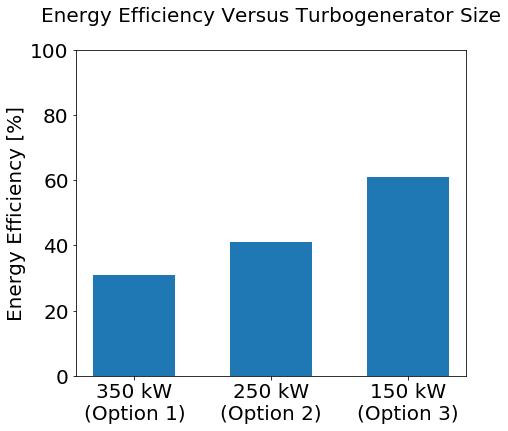

In [23]:
width = 0.6

x1 = [1,2,3]

# input power in kWh
P_opt1 = np.array([230.7, 157.86])
P_opt2 = np.array([174.1, 114.47])
P_opt3 = np.array([117.63, 96.07])

P_on = np.array([230.7, 174.1, 117.63])
P_off = np.array([157.86, 114.47, 96.07])

# output power in kWh
eff = (0.8*0.955)
P_out = 93.71*eff

# energy effiecincies for each option
E_opt1 = (P_out/P_opt1)*100
E_opt2 = (P_out/P_opt2)*100
E_opt3 = (P_out/P_opt3)*100

E_off = (P_out/P_off)*100
E_on = (P_out/P_on)*100

labels = ['350 kW', '250 kW', '150 kW']


plt.figure(figsize = [7,6])
plt.bar(x1,E_on, width)
plt.xticks([1,2,3], labels = ('350 kW\n(Option 1)', '250 kW\n(Option 2)', '150 kW\n(Option 3)'))
plt.yticks([0,20,40,60,80,100])
plt.ylabel('Energy Efficiency [%]')
plt.title('Energy Efficiency Versus Turbogenerator Size\n')

plt.savefig('Eff1')

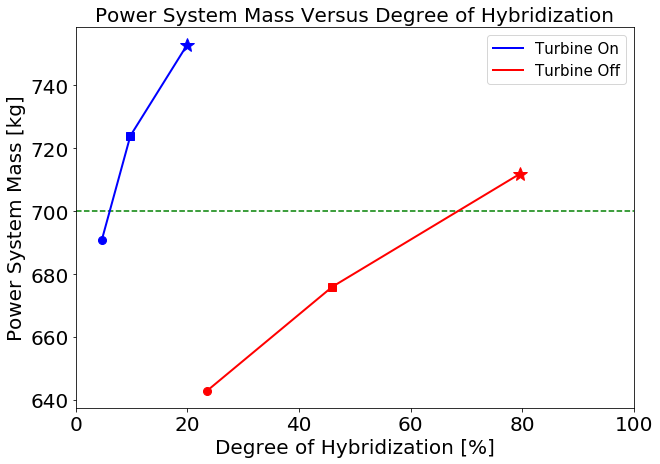

In [24]:
DOH_on = [4.7, 9.8, 20]
mass_on = [691,724,753]
DOH_off = [23.6,46,79.7]
mass_off = [643,676,712]

plt.figure(figsize = [10,7])
plt.axhline(700, color = 'g', linestyle = '--')
plt.plot(DOH_on, mass_on, 'b-', label = 'Turbine On', linewidth = 2)
plt.plot(DOH_off, mass_off, 'r-', label = 'Turbine Off', linewidth = 2)

plt.plot(DOH_on[0], mass_on[0], 'bo', markersize = 8)
plt.plot(DOH_off[0], mass_off[0], 'ro', markersize = 8)

plt.plot(DOH_on[1], mass_on[1], 'bs', markersize = 8)
plt.plot(DOH_off[1], mass_off[1], 'rs', markersize = 8)

plt.plot(DOH_on[2], mass_on[2], 'b*', markersize = 15)
plt.plot(DOH_off[2], mass_off[2], 'r*', markersize = 15)

plt.xticks([0, 20,40,60,80,100])
plt.xlabel('Degree of Hybridization [%]')
plt.ylabel('Power System Mass [kg]')
plt.title('Power System Mass Versus Degree of Hybridization')
plt.legend(fontsize = 15)

# plt.savefig('P v DOH')